## The autoencoder class

In [2]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import r2_score
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from scipy.optimize import minimize
from IPython.display import clear_output
import warnings
from autoencoder import Autoencoder
warnings.filterwarnings("ignore")



create the object by passing the number of qubit of the encoder and the trash space as well as a device

In [3]:
n_trash_qubit=3
n_qubit_autoencoder=5
n_qubit=n_qubit_autoencoder+n_trash_qubit+1 
dvc = qml.device('default.qubit', wires=n_qubit, shots=None)

ae = Autoencoder('fd',n_qubit_autoencoder,n_trash_qubit,dvc)


To Train the model, pass the values X as input.
given $X=\{x_1,\dots x_n\}$ with $x_i \in \{0,1\}$ each $x_i$ 
correspont to the parameter $\alpha$ in the formulation for an isotropic state

$$ \rho_\alpha = \frac{1-\alpha}{d^2}Id + \alpha\ket{\Phi^+}\bra{\Phi^+} $$

You also need to set up the optimizer and decide the number of epochs. Note that batching is not set up yet

In [4]:
epochs= 100
n=100
opt=AdamOptimizer(stepsize=.2)
X=np.random.rand(n)
np.random.shuffle(X)

history = ae.train(X,opt,epochs,20)


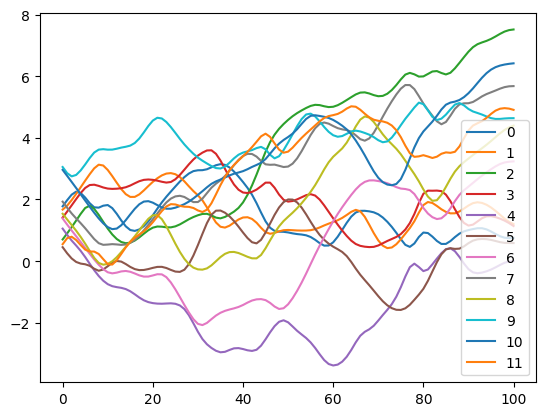

In [5]:
ae.plot_weights()

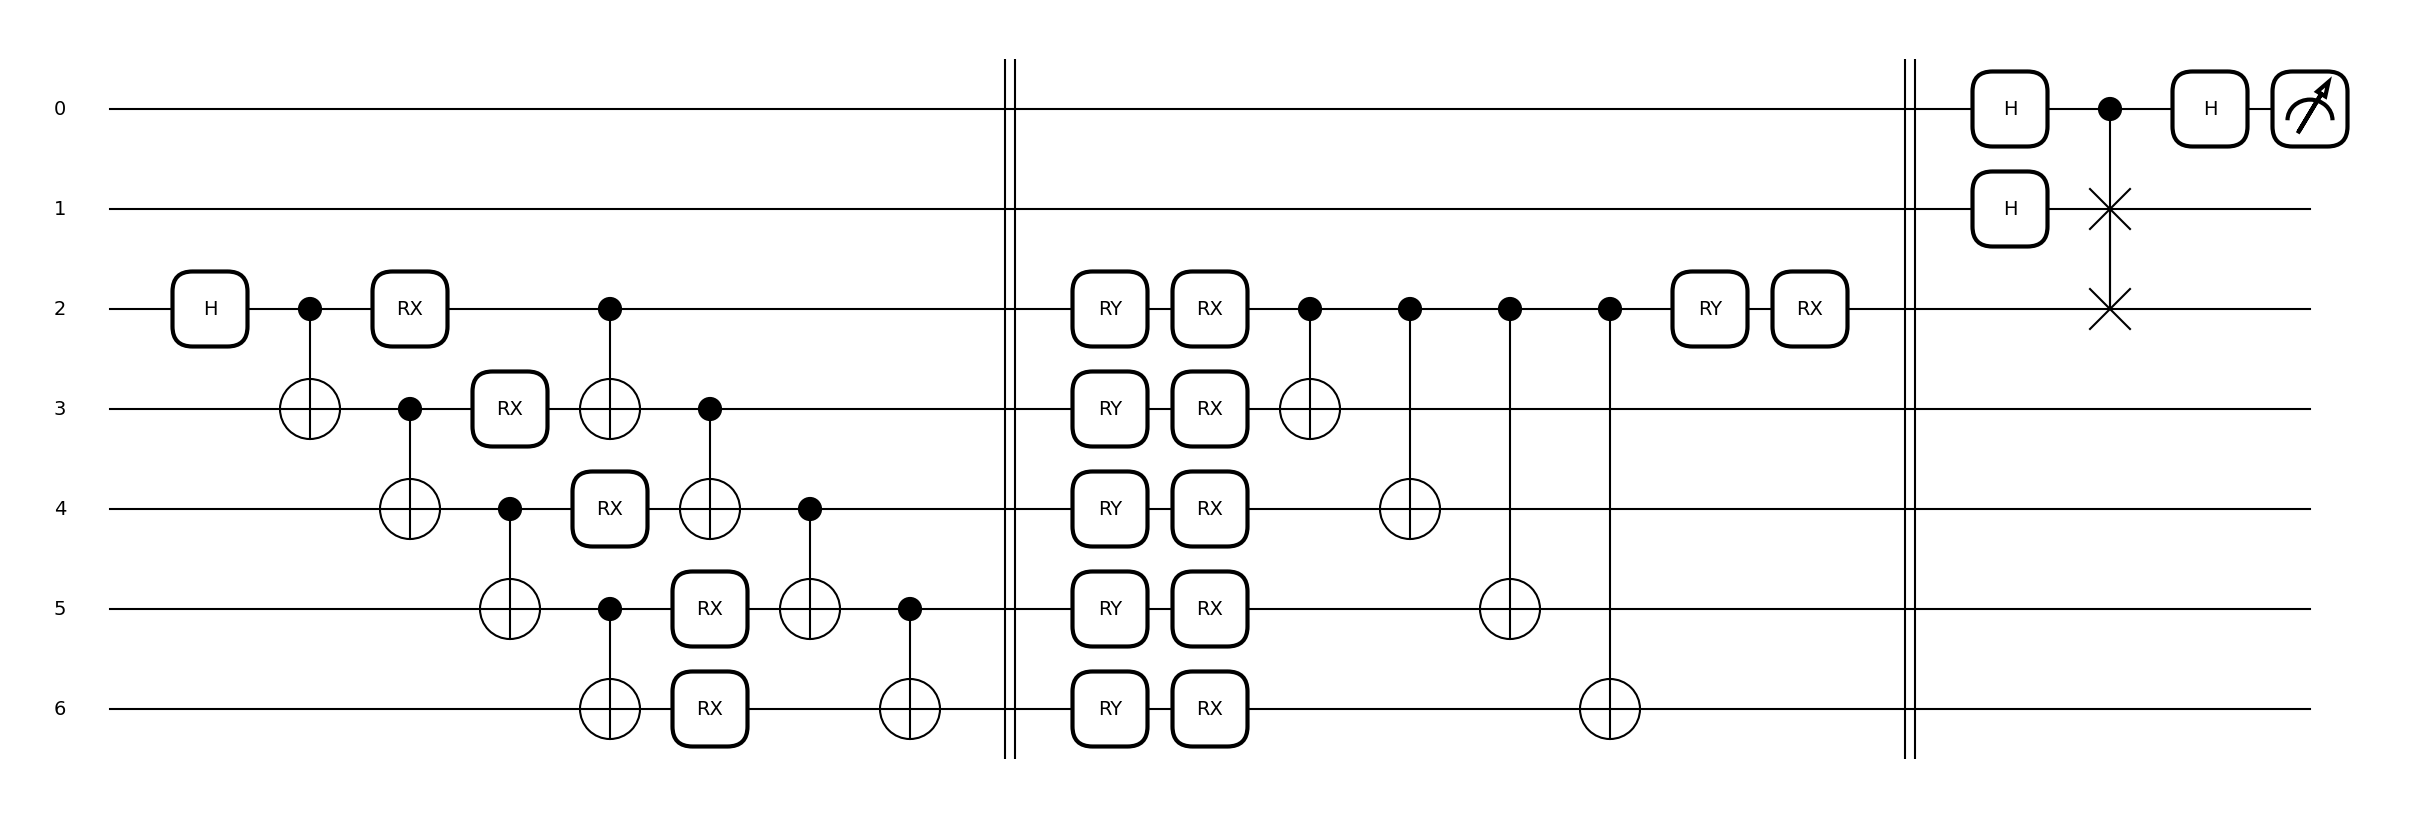

In [6]:
ae.plot_cirq()

you can plot the training circuit as well as the loss function

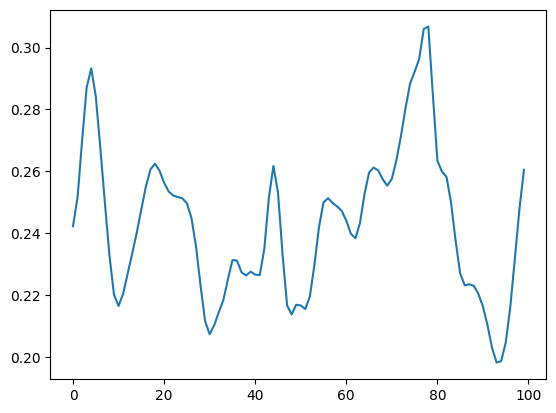

In [7]:
ae.plot_loss()


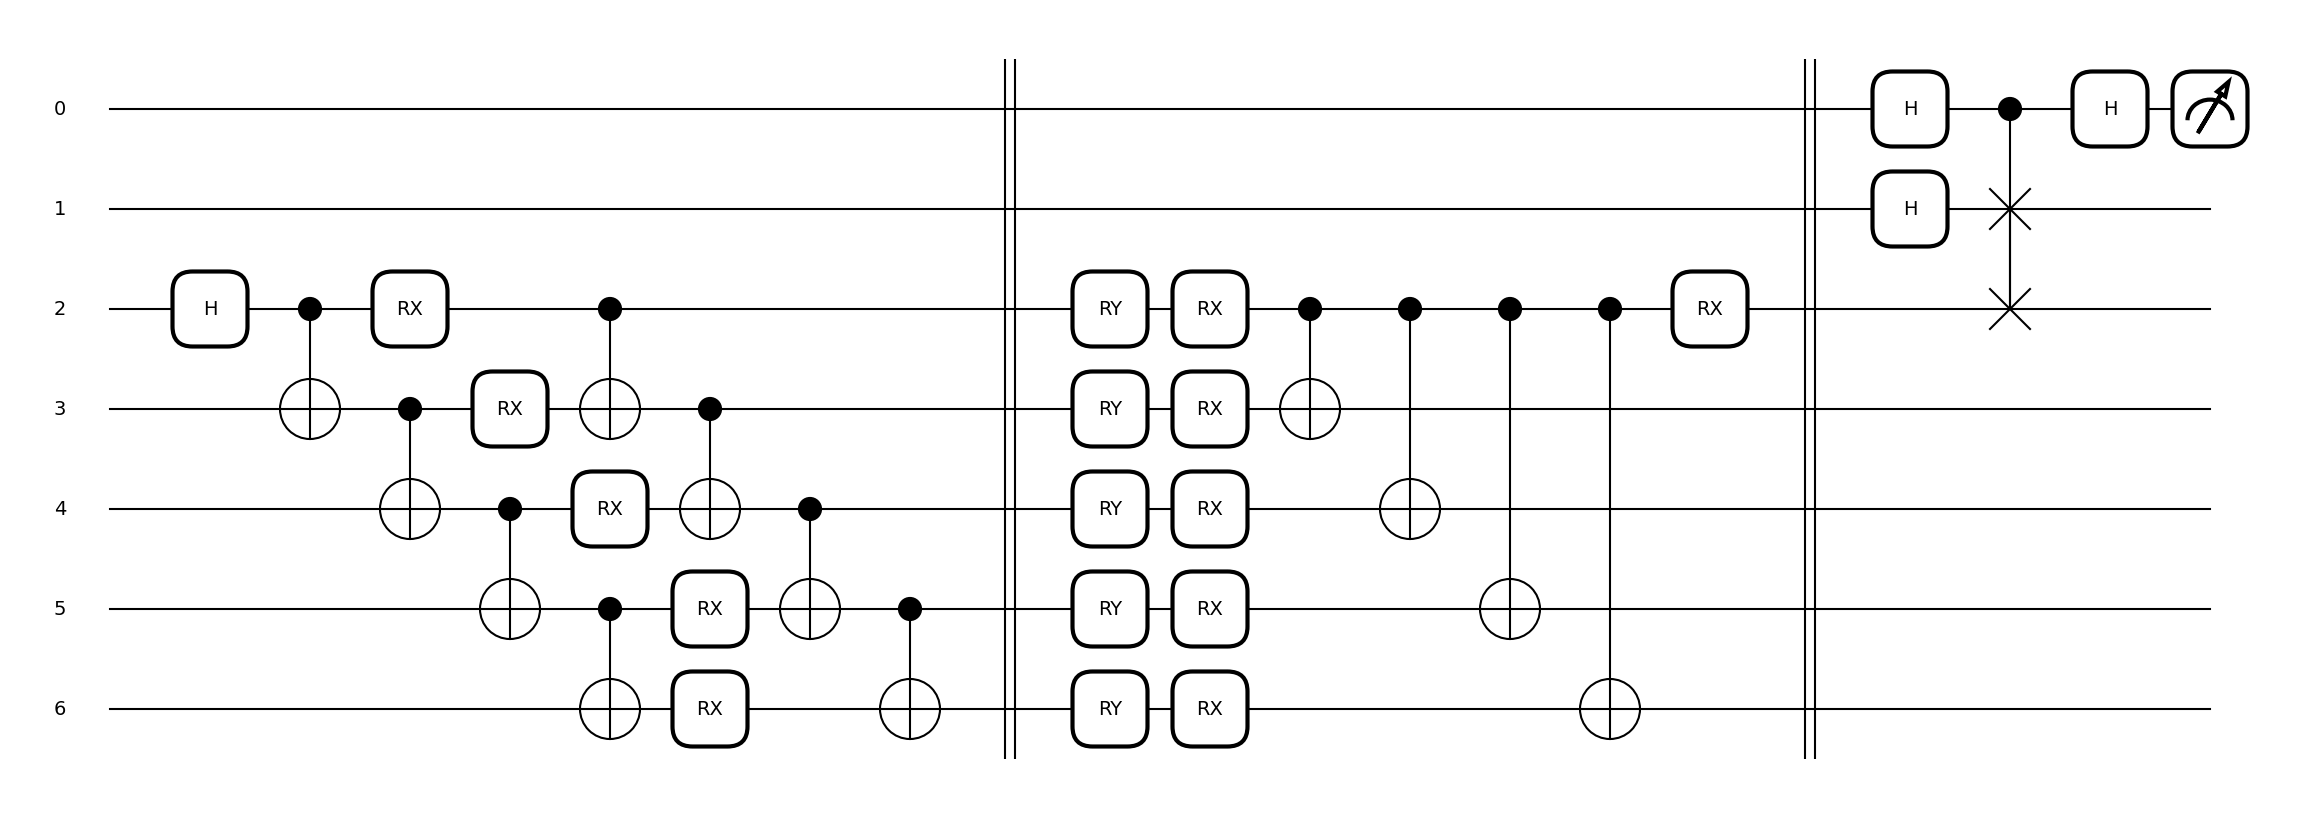

In [7]:
ae.plot_cirq()

## Add the trained autoencoder to a new circuit

Use the autoencoder to perform SWAP test for the dimentionality reduced state


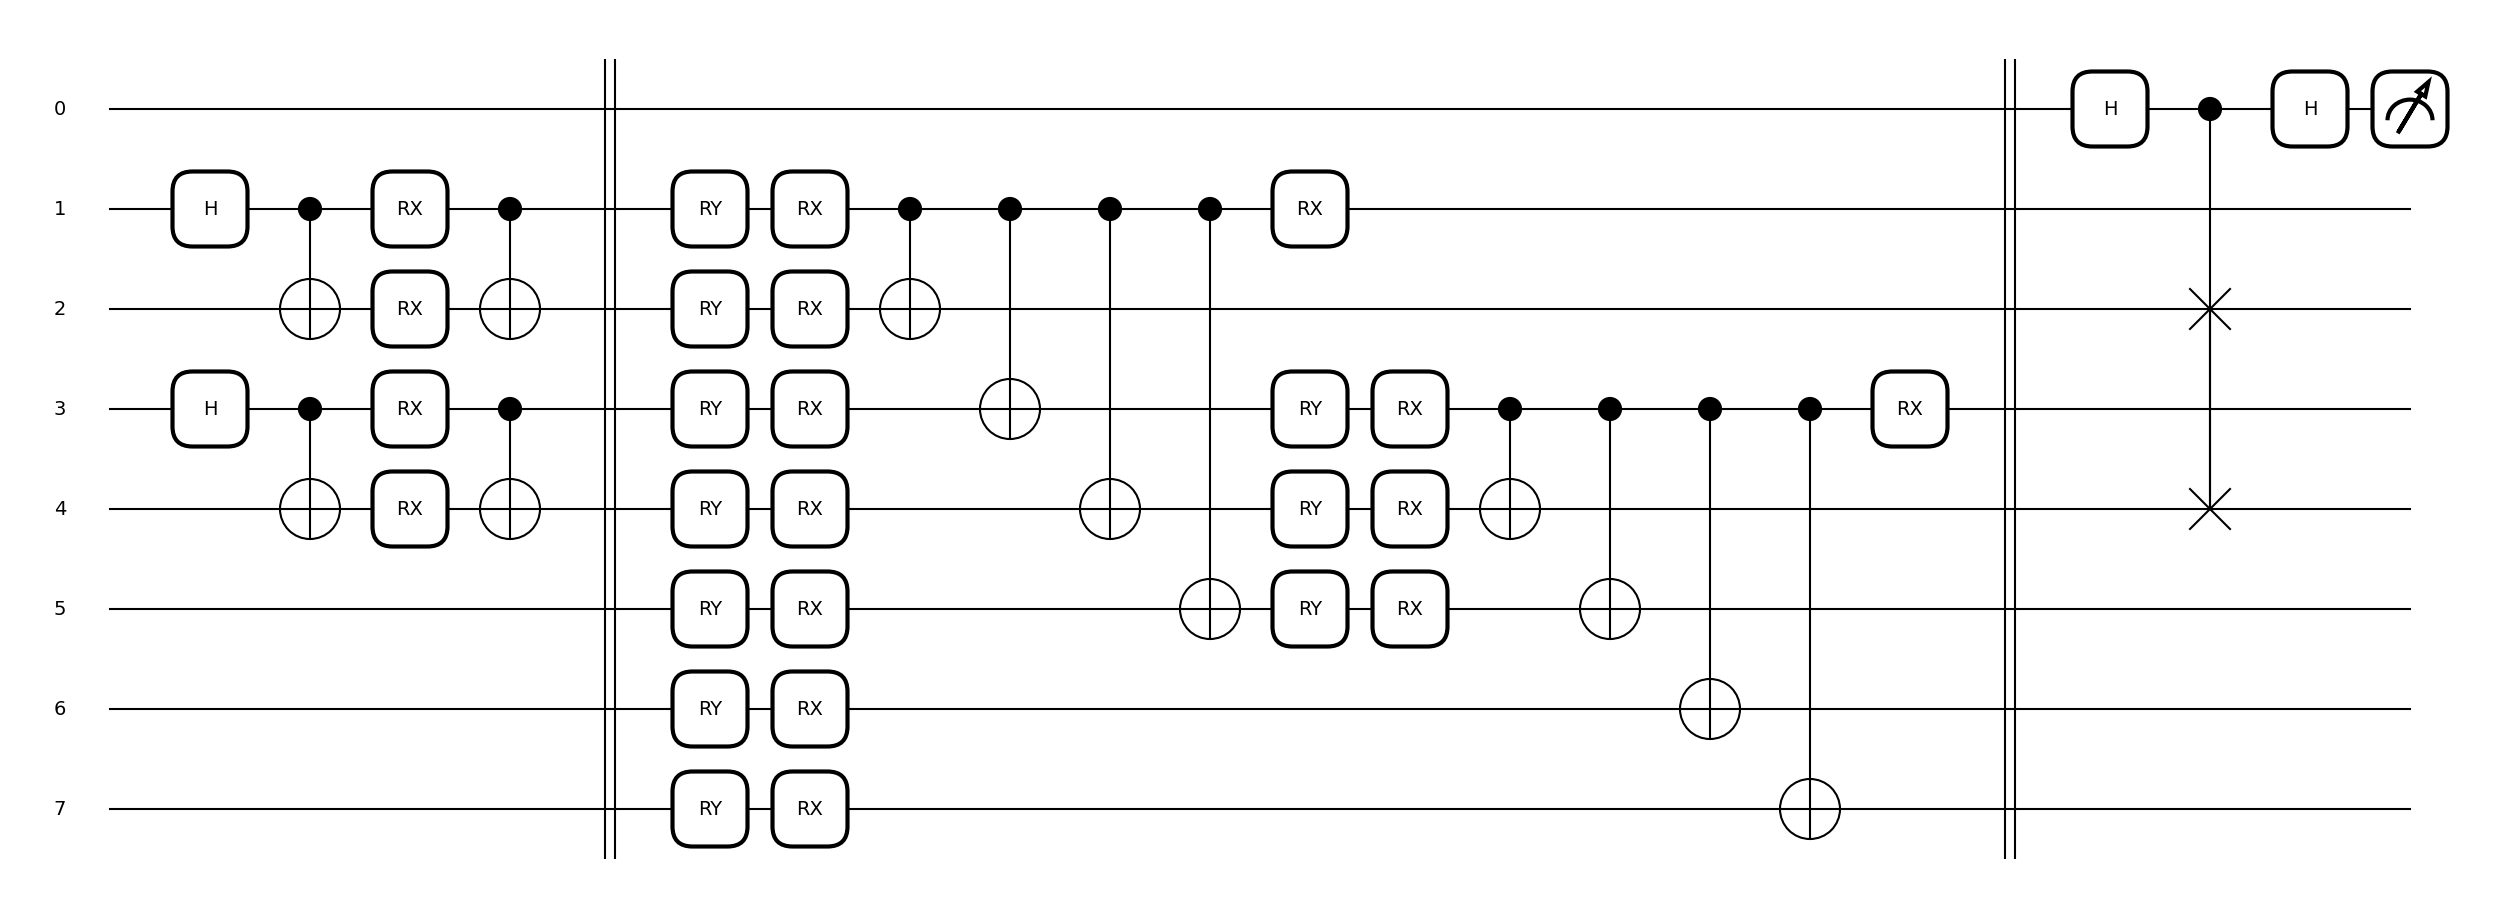

In [8]:

@qml.qnode(qml.device('default.qubit', wires=5, shots=10000))
def pio(param):
    isotropic_state(param[0],[1,2])
    isotropic_state(param[1],[3,4])
    
    qml.Barrier()
    ae.get_cirq(1)
    ae.get_cirq(3)

    qml.Barrier()
    original_swap([(2,4)])
    return qml.probs([0])

fig, ax = qml.draw_mpl(pio)([1,2])
plt.show()


Test the Swap test with the original state



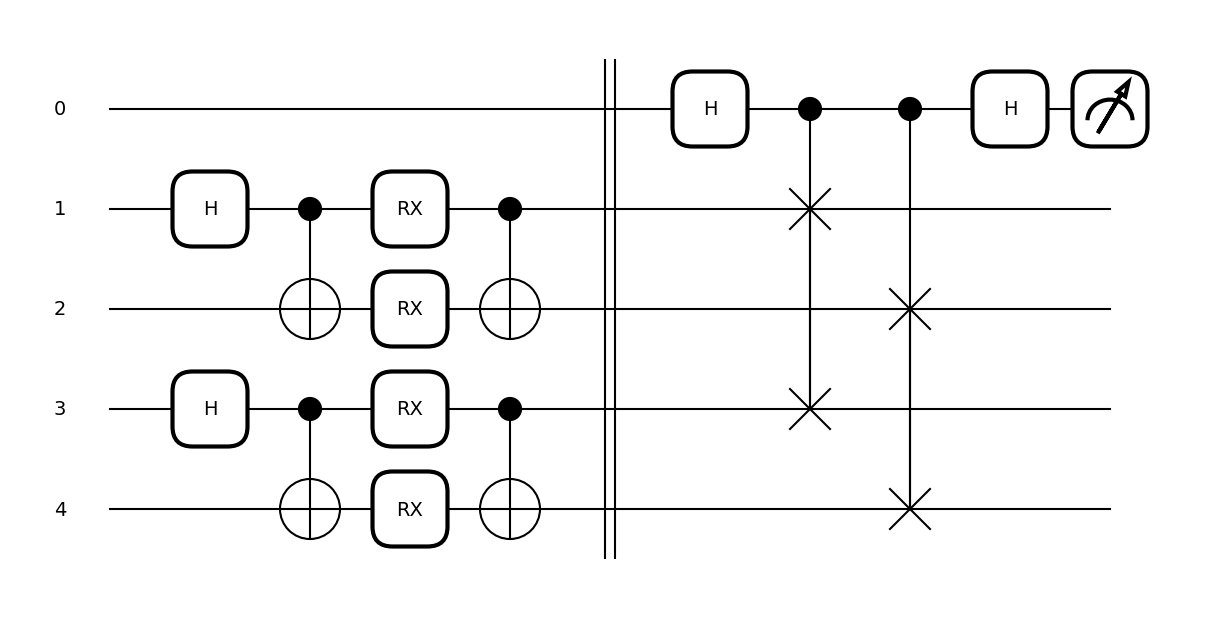

In [9]:

@qml.qnode(qml.device('default.qubit', wires=5, shots=10000))
def pio2(param):
    isotropic_state(param[0],[1,2])
    isotropic_state(param[1],[3,4])
    
    qml.Barrier()
    original_swap([(1,3),(2,4)])
    return qml.probs([0])

fig, ax = qml.draw_mpl(pio2)([1,2])
plt.show()


And finally compare the results obtained by the two 

In [10]:

c1=[]
c2=[]
for a in np.linspace(0,1,100):
    res1 = pio([a,0])
    res2 = pio2([a,0])
    c1.append(res1[0])
    c2.append(res2[0])


WireError: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {5, 6, 7}

Plot and analize

MSE of the error is 3.558510000000005e-05


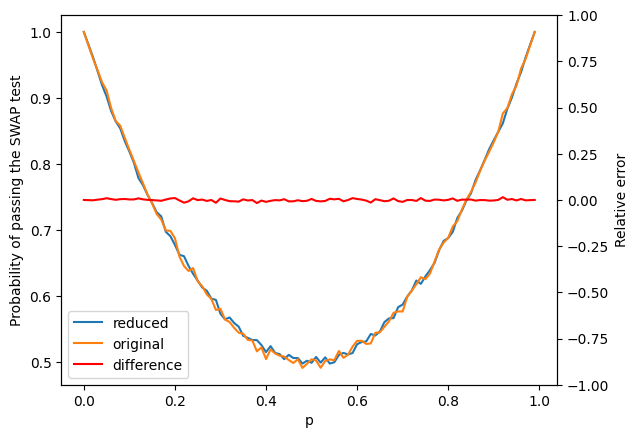

In [9]:

fig, ax = plt.subplots()
ax2 = ax.twinx()

lns1=ax.plot( np.array(range(len(c1)))/100,c1,label=['reduced'])
lns2=ax.plot( np.array(range(len(c2)))/100,c2,label=['original'])
errors = np.array(c2)-np.array(c1)
lns3=ax2.plot( np.array(range(len(c2)))/100,errors,label=['difference'],color='red')
from sklearn.metrics import mean_squared_error as mse 
print(f'MSE of the error is {mse(c1,c2)}')
ax2.set_ylim([-1,1])
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel("p")
ax.set_ylabel(r"Probability of passing the SWAP test")
ax2.set_ylabel(r"Relative error")
plt.show();